# Kaggle - Space Titanic - Spark framework

This notebooks is used as practice for ML applied to Kaggle Space Titanic training problem and pySpark practice
https://www.kaggle.com/competitions/spaceship-titanic/data?select=train.csv

In [214]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, split
from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation, ChiSquareTest
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, MinMaxScaler
import pandas as pd
import numpy as np
import seaborn as sns

## Import data to local Spark Framework

Load data from CSV and organize schema

In [215]:
# set env viroment for localhost if needed
spark = SparkSession.builder.config("spark.driver.host", "localhost").getOrCreate()

train_spark = spark.read.format('csv').option("header",True).load('./train.csv')
test_spark = spark.read.format('csv').option("header",True).load('./test.csv')

In [216]:
train_spark.show()
train_spark.printSchema()

+-----------+----------+---------+-----+-------------+----+-----+-----------+---------+------------+------+------+------------------+-----------+
|PassengerId|HomePlanet|CryoSleep|Cabin|  Destination| Age|  VIP|RoomService|FoodCourt|ShoppingMall|   Spa|VRDeck|              Name|Transported|
+-----------+----------+---------+-----+-------------+----+-----+-----------+---------+------------+------+------+------------------+-----------+
|    0001_01|    Europa|    False|B/0/P|  TRAPPIST-1e|39.0|False|        0.0|      0.0|         0.0|   0.0|   0.0|   Maham Ofracculy|      False|
|    0002_01|     Earth|    False|F/0/S|  TRAPPIST-1e|24.0|False|      109.0|      9.0|        25.0| 549.0|  44.0|      Juanna Vines|       True|
|    0003_01|    Europa|    False|A/0/S|  TRAPPIST-1e|58.0| True|       43.0|   3576.0|         0.0|6715.0|  49.0|     Altark Susent|      False|
|    0003_02|    Europa|    False|A/0/S|  TRAPPIST-1e|33.0|False|        0.0|   1283.0|       371.0|3329.0| 193.0|      Sola

## Data wrangling

In [318]:
def spark_df_format(input_spark_df):
       spark_df = input_spark_df

       # cast types/schema
       spark_df = spark_df.withColumn("CryoSleep",col("CryoSleep").cast("boolean")).withColumn("CryoSleep",col("CryoSleep").cast("integer"))
       spark_df = spark_df.withColumn("VIP",col("VIP").cast("boolean")).withColumn("VIP",col("VIP").cast("integer"))
       spark_df = spark_df.withColumn("Transported",col("Transported").cast("boolean")).withColumn("Transported",col("Transported").cast("integer"))
       spark_df = spark_df.withColumn("Age",col("Age").cast("float"))
       spark_df = spark_df.withColumn("RoomService",col("RoomService").cast("float"))
       spark_df = spark_df.withColumn("FoodCourt",col("FoodCourt").cast("float"))
       spark_df = spark_df.withColumn("ShoppingMall",col("ShoppingMall").cast("float"))
       spark_df = spark_df.withColumn("Spa",col("Spa").cast("float"))
       spark_df = spark_df.withColumn("VRDeck",col("VRDeck").cast("float"))

       # drop na for transported
       spark_df.dropna(subset='Transported')

       # fill na for booleans
       spark_df = spark_df.fillna(subset=['CryoSleep','VIP'],value=-1)

       # breakdown cabin address
       spark_df =  spark_df.withColumn('deck', split(spark_df['Cabin'], '/').getItem(0)) \
              .withColumn('num', split(spark_df['Cabin'], '/').getItem(1)) \
              .withColumn('side', split(spark_df['Cabin'], '/').getItem(2))
       spark_df = spark_df.withColumn("num",col("num").cast("float"))

       return spark_df

def spark_pipeline_transform(input_spark_df, pipeline = None):
       spark_df = input_spark_df
       if pipeline is None:
              cate_list = ['HomePlanet','Destination','deck','side']
              bool_list = ['Transported','CryoSleep','VIP']
              float_list = ['Age','RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','num']
              
              stages_list = []

              # convert strings to indexes
              stages_list = stages_list + [
                     StringIndexer(inputCol=c, outputCol=c+'_idx', handleInvalid='keep')
                     for c in cate_list
              ]

              # vectorize columns
              stages_list = stages_list + [
                     VectorAssembler(inputCols=[c+'_idx'], outputCol=c+'_vec', handleInvalid='keep')
                     for c in cate_list
              ]
              stages_list = stages_list + [
                     VectorAssembler(inputCols=[c], outputCol=c+'_vec', handleInvalid='keep')
                     for c in float_list+bool_list
              ]

              # minmax scale floats
              stages_list = stages_list + [
                     MinMaxScaler(inputCol=c+"_vec", outputCol=c+"_scaled") for c in float_list
              ]

              # one hot encode
              stages_list = stages_list + [OneHotEncoder(inputCols=[c+"_idx" for c in cate_list],
                     outputCols=[c+"_ohe" for c in cate_list], handleInvalid='keep'
              )]

              pipeline = Pipeline(stages=stages_list)

       spark_df = pipeline.fit(spark_df).transform(spark_df)

       # build continuous and categorical part (data analytics)
       cont_spark_df = spark_df.select(['Transported']+[c for c in float_list])
       cate_spark_df = spark_df.select(['Transported_vec']+[c+'_vec' for c in cate_list+bool_list])
       
       return spark_df, cont_spark_df, cate_spark_df, pipeline

In [319]:
full_df = spark_df_format(train_spark)
full_df, cont_spark_df, cate_spark_df, pipeline = spark_pipeline_transform(full_df)
cont_spark_df.show()
cont_spark_df.head(5)

+-----------+----+-----------+---------+------------+------+------+----+
|Transported| Age|RoomService|FoodCourt|ShoppingMall|   Spa|VRDeck| num|
+-----------+----+-----------+---------+------------+------+------+----+
|          0|39.0|        0.0|      0.0|         0.0|   0.0|   0.0| 0.0|
|          1|24.0|      109.0|      9.0|        25.0| 549.0|  44.0| 0.0|
|          0|58.0|       43.0|   3576.0|         0.0|6715.0|  49.0| 0.0|
|          0|33.0|        0.0|   1283.0|       371.0|3329.0| 193.0| 0.0|
|          1|16.0|      303.0|     70.0|       151.0| 565.0|   2.0| 1.0|
|          1|44.0|        0.0|    483.0|         0.0| 291.0|   0.0| 0.0|
|          1|26.0|       42.0|   1539.0|         3.0|   0.0|   0.0| 2.0|
|          1|28.0|        0.0|      0.0|         0.0|   0.0|  NULL| 0.0|
|          1|35.0|        0.0|    785.0|        17.0| 216.0|   0.0| 3.0|
|          1|14.0|        0.0|      0.0|         0.0|   0.0|   0.0| 1.0|
|          1|34.0|        0.0|      0.0|        NUL

[Row(Transported=0, Age=39.0, RoomService=0.0, FoodCourt=0.0, ShoppingMall=0.0, Spa=0.0, VRDeck=0.0, num=0.0),
 Row(Transported=1, Age=24.0, RoomService=109.0, FoodCourt=9.0, ShoppingMall=25.0, Spa=549.0, VRDeck=44.0, num=0.0),
 Row(Transported=0, Age=58.0, RoomService=43.0, FoodCourt=3576.0, ShoppingMall=0.0, Spa=6715.0, VRDeck=49.0, num=0.0),
 Row(Transported=0, Age=33.0, RoomService=0.0, FoodCourt=1283.0, ShoppingMall=371.0, Spa=3329.0, VRDeck=193.0, num=0.0),
 Row(Transported=1, Age=16.0, RoomService=303.0, FoodCourt=70.0, ShoppingMall=151.0, Spa=565.0, VRDeck=2.0, num=1.0)]

### Correlation check

In [320]:
# define function to create and plot correlation matrix with Spark dataframe
def spark_corr(spark_df, plot=False):
    cor_df = VectorAssembler(inputCols=spark_df.columns, outputCol='features',handleInvalid='skip').transform(spark_df)
    cor_df = Correlation.corr(cor_df,column='features')
    
    corr_matrix = cor_df.collect()[0][0].toArray().tolist() 
    corr_matrix = pd.DataFrame(data=corr_matrix, columns=spark_df.columns, index=spark_df.columns)

    if plot:
        sns.heatmap(corr_matrix, annot=True)
        pass

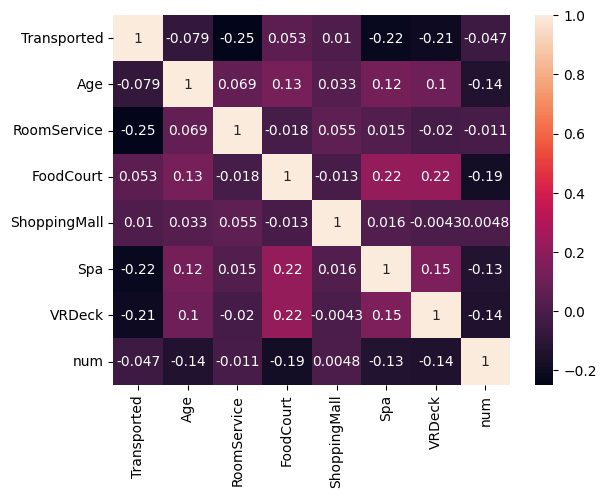

In [321]:
spark_corr(cont_spark_df, True)

### P-Value check

In [322]:
def spark_chi_sq(spark_df, targetName = 'target', featureName = 'feature'):
    spark_df.crosstab(targetName,featureName).show()
    chi_df = ChiSquareTest.test(spark_df, featureName, targetName)

    return chi_df

In [328]:
#  ['VIP','CryoSleep','HomePlanet','Destination_ohe','deck_ohe','side_ohe']
aux = spark_chi_sq(full_df, 'Transported', 'VIP_vec')
aux.show(truncate=False)

+-------------------+------+-----+-----+
|Transported_VIP_vec|[-1.0]|[0.0]|[1.0]|
+-------------------+------+-----+-----+
|                  0|    99| 4093|  123|
|                  1|   104| 4198|   76|
+-------------------+------+-----+-----+

+-----------------------+----------------+--------------------+
|pValues                |degreesOfFreedom|statistics          |
+-----------------------+----------------+--------------------+
|[0.0023608448102931945]|[2]             |[12.097471507075117]|
+-----------------------+----------------+--------------------+



In [ ]:
aux.select(['pValues']).collect()[0][0].toArray().tolist()

[0.0]

In [246]:
aux.select('degreesOfFreedom').collect()

[Row(degreesOfFreedom=[3])]

In [311]:
full_df.show()

+-----------+----------+---------+-----+-------------+----+---+-----------+---------+------------+------+------+------------------+-----------+----+----+----+--------------+---------------+--------+--------+--------------+---------------+--------+--------+-------+---------------+-------------+----------------+--------+----------+-------+---------------+-------------+-------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+---------------+-------------+-------------+
|PassengerId|HomePlanet|CryoSleep|Cabin|  Destination| Age|VIP|RoomService|FoodCourt|ShoppingMall|   Spa|VRDeck|              Name|Transported|deck| num|side|HomePlanet_idx|Destination_idx|deck_idx|side_idx|HomePlanet_vec|Destination_vec|deck_vec|side_vec|Age_vec|RoomService_vec|FoodCourt_vec|ShoppingMall_vec| Spa_vec|VRDeck_vec|num_vec|Transported_vec|CryoSleep_vec|VIP_vec|          Age_scaled|  RoomService_scal

# Machine Learning Models

In this notebook it will be tested a simple decision tree model and XBoost model for comparrison

## Random forest